In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Looking into the class balance to identify those classes with the lowest representation in the dataset

In [3]:
from IPython.display import display

# Load the train metadata file
train_metadata = pd.read_csv('../starting_metadata/train_metadata.csv')

# Summarise the data by taxonID_index
summary = train_metadata['taxonID_index'].value_counts().sort_index()
# Display summary statistics

print("Summary statistics for class distribution:")
display(summary.describe().to_frame().T)

# Display the 10 classes with the lowest representation as a DataFrame
print("\n10 classes with the lowest number of examples:")
lowest_classes = summary.nsmallest(10).reset_index()
lowest_classes.columns = ['taxonID_index', 'count']
display(lowest_classes)


Summary statistics for class distribution:


,count,mean,std,min,25%,50%,75%,max
count,183.0,141.327869,141.218487,13.0,47.0,96.0,179.0,875.0



10 classes with the lowest number of examples:


,taxonID_index,count
0,148,13
1,89,22
2,108,23
3,149,23
4,146,24
5,118,25
6,36,26
7,153,26
8,59,27
9,103,27


In [4]:
rare_classes = summary[summary < 200]
num_images_under_200 = rare_classes.sum()
print(f"Total number of images for classes with less than 200: {num_images_under_200}")

Total number of images for classes with less than 200: 11975


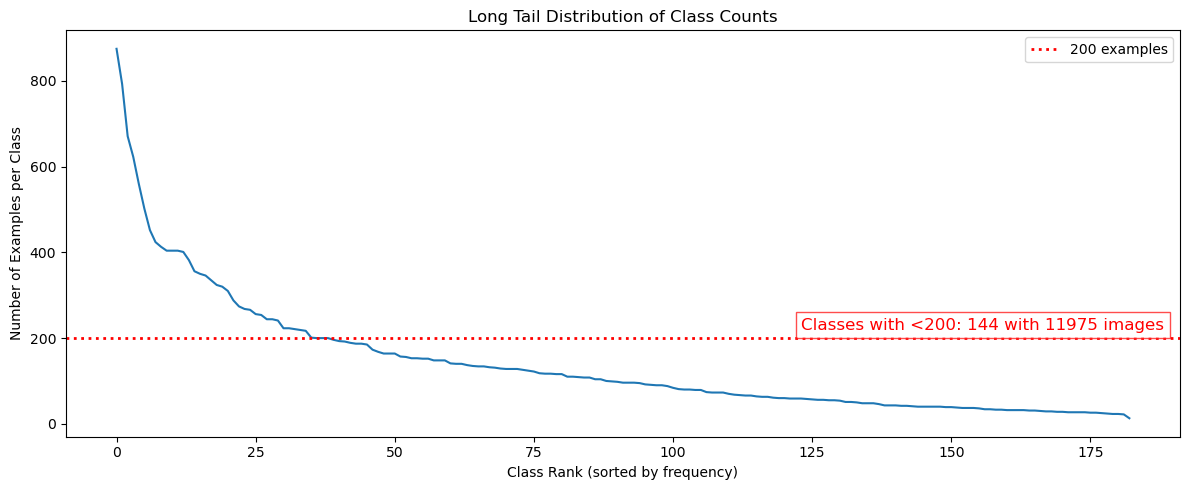

In [5]:
# Sort by count in descending order
sorted_counts = summary.sort_values(ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 5))
plt.plot(sorted_counts.values)
plt.title('Long Tail Distribution of Class Counts')
plt.xlabel('Class Rank (sorted by frequency)')
plt.ylabel('Number of Examples per Class')
plt.tight_layout()

plt.axhline(200, color='red', linestyle='dotted', linewidth=2, label='200 examples')
plt.legend()
num_classes_under_200 = (summary < 200).sum()
plt.text(
    x=len(sorted_counts) - 60,
    y=220,
    s=f'Classes with <200: {num_classes_under_200} with {num_images_under_200} images',
    color='red',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='red')
)
plt.show()

In [6]:
def calculate_metadata_cost(n_rows):
    # Define the cost per column
    column_costs = {
        'eventDate': 2,
        'Latitude': 1,
        'Longitude': 1,
        'Habitat': 2,
        'Substrate': 2
    }
    # Total cost per row
    total_cost_per_row = sum(column_costs.values())
    # Total cost for n_rows
    total_cost = n_rows * total_cost_per_row
    return total_cost

In [7]:
print(f'Calcuating the cost of just the lat long for 11,975 rows: {11975 * 2}')
calculate_metadata_cost(11975)

Calcuating the cost of just the lat long for 11,975 rows: 23950


95800

So if we wanted to take all the metadata for the classes that have less than 200 images plus a distribution of the remaining classes would come to about 2304 credits.
 

In [8]:
def select_rows_with_metadata(df, class_col, n=5, metadata_cols=None):
    if metadata_cols is None:
        metadata_cols = ['Habitat', 'Latitude', 'Longitude', 'Substrate', 'eventDate']
    selected = []
    for class_id, group in df.groupby(class_col):
        # Prioritize rows with any metadata present
        has_metadata = group[metadata_cols].notnull().any(axis=1)
        group_with_metadata = group[has_metadata]
        group_without_metadata = group[~has_metadata]
        # Select up to n rows, prioritizing those with metadata
        selected_rows = pd.concat([
            group_with_metadata.sample(n=min(len(group_with_metadata), n), random_state=42),
            group_without_metadata.sample(n=max(0, n - len(group_with_metadata)), random_state=42)
        ])
        selected.append(selected_rows)
    return pd.concat(selected, ignore_index=True)

selected_5_per_class = select_rows_with_metadata(
    train_metadata, 
    class_col='taxonID_index', 
    n=5, 
    metadata_cols=['Habitat', 'Latitude', 'Longitude', 'Substrate', 'eventDate']
)

print(f"Total selected rows: {len(selected_5_per_class)}")
display(selected_5_per_class.head(10))

Total selected rows: 915


,filename_index,Habitat,Latitude,Longitude,Substrate,eventDate,taxonID_index
0,fungi_train009155.jpg,NaN,NaN,NaN,dead wood (including bark),NaN,0
1,fungi_train024253.jpg,NaN,55.941317,NaN,NaN,NaN,0
2,fungi_train008444.jpg,Deciduous woodland,NaN,NaN,NaN,NaN,0
3,fungi_train017955.jpg,Deciduous woodland,NaN,NaN,NaN,NaN,0
4,fungi_train000068.jpg,NaN,NaN,12.293118,NaN,NaN,0
5,fungi_train000768.jpg,NaN,NaN,11.843120,NaN,NaN,1
6,fungi_train013082.jpg,NaN,NaN,NaN,NaN,2011-08-28,1
7,fungi_train008524.jpg,NaN,NaN,NaN,NaN,2018-09-15,1
8,fungi_train000909.jpg,NaN,NaN,9.700265,NaN,NaN,1
9,fungi_train015289.jpg,NaN,NaN,12.445812,NaN,NaN,1


In [9]:
nans_per_column = selected_5_per_class.isna().sum()
print("Number of NaNs per column in selected_5_per_class:")
print(nans_per_column)
total_nans = nans_per_column.sum()
print(f"Total number of NaNs in selected_5_per_class: {total_nans}")

Number of NaNs per column in selected_5_per_class:
filename_index      0
Habitat           748
Latitude          769
Longitude         755
Substrate         769
eventDate         774
taxonID_index       0
dtype: int64
Total number of NaNs in selected_5_per_class: 3815


In [10]:
data = []
metadata_cols = ['Habitat', 'Latitude', 'Longitude', 'Substrate', 'eventDate']

for _, row in selected_5_per_class.iterrows():
    for col in metadata_cols:
        if pd.isnull(row[col]):
            data.append([row['filename_index'], col])
print(f"Total number of missing metadata entries: {len(data)}")

Total number of missing metadata entries: 3815


In [11]:
calculate_metadata_cost(len(selected_5_per_class))

7320

In [12]:
metadata_costs = {'eventDate': 2, 'Latitude': 1, 'Longitude': 1, 'Habitat': 2, 'Substrate': 2}
cost = 0
for d in data:
   cost += metadata_costs.get(d[1], 0)

print("Total metadata cost:", cost)

Total metadata cost: 6106


In [13]:
import csv

# Specify the output file name
output_file = "shoppinglist.csv"

# Write data to the CSV file
with open(output_file, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    # Write rows into the file
    writer.writerows(data)

print(f"Data has been successfully written to '{output_file}'.")

Data has been successfully written to 'shoppinglist.csv'.


## Second round of shopping 

In [15]:
metadata = pd.read_csv(r'..\starting_metadata\metadata.csv')

#### Rows for completion 

In [28]:
# Get the indices (class IDs) of classes with less than 200 images
sub_200_class_ids = rare_classes.index

# Filter train_metadata for rows belonging to these classes
sub_200_rows = train_metadata[train_metadata['taxonID_index'].isin(sub_200_class_ids)]

# Only consider rows where at least one of Latitude or Longitude is not null
has_latlong = sub_200_rows[['Latitude', 'Longitude']].notnull().any(axis=1)
sub_200_with_latlong = sub_200_rows[has_latlong]

# Count how many latitude and longitude values are missing in the sample
lat_missing = sub_200_with_latlong['Latitude'].isna().sum()
long_missing = sub_200_with_latlong['Longitude'].isna().sum()

latlong_cost = lat_missing + long_missing
print(f"Total cost for lat long: {latlong_cost}")

Total cost for lat long: 390


#### looking at cost for 50% or remaining rare classes 

In [34]:
no_latlong = sub_200_rows[['Latitude', 'Longitude']].isnull().all(axis=1)
sub_200_withouth_latlong = sub_200_rows[no_latlong]
print(f"Total number of rows without lat long: {len(sub_200_withouth_latlong)}")

sampled_rows = (
    sub_200_withouth_latlong
    .groupby('taxonID_index', group_keys=False)
    .apply(lambda x: x.sample(frac=0.5, random_state=42) if len(x) > 1 else x)
)

len_sampled = len(sampled_rows)
print(f"Cost for 50% sampled rows: {len_sampled*2}")

Total number of rows without lat long: 11585
Cost for 50% sampled rows: 11580


C:\Users\ngrec\AppData\Local\Temp\ipykernel_44528\1456028254.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.5, random_state=42) if len(x) > 1 else x)



## Checking cost for all the log lat minus the ban list 

In [35]:
# Load the cluster index file
cluster_index = pd.read_csv(r'..\cluster_index.csv')

# Filter train_metadata to only include rows with filename_index present in cluster_index
filtered_train = train_metadata[train_metadata['filename_index'].isin(cluster_index['filename_index'])]

print(f"Filtered train_metadata shape: {filtered_train.shape}")
display(filtered_train.head())

Filtered train_metadata shape: (25863, 7)


,filename_index,Habitat,Latitude,Longitude,Substrate,eventDate,taxonID_index
0,fungi_train000000.jpg,NaN,NaN,NaN,NaN,NaN,66
1,fungi_train000001.jpg,NaN,NaN,NaN,NaN,NaN,174
2,fungi_train000002.jpg,NaN,NaN,NaN,NaN,NaN,50
3,fungi_train000003.jpg,NaN,NaN,NaN,NaN,NaN,72
4,fungi_train000004.jpg,NaN,NaN,NaN,NaN,NaN,30


In [36]:
# Calculate the number of missing Latitude and Longitude values in filtered_train
missing_lat = filtered_train['Latitude'].isna().sum()
missing_long = filtered_train['Longitude'].isna().sum()

# Each missing Latitude or Longitude costs 1 credit (from metadata_costs)
total_latlong_cost = missing_lat * metadata_costs['Latitude'] + missing_long * metadata_costs['Longitude']

print(f"Missing Latitude: {missing_lat}")
print(f"Missing Longitude: {missing_long}")
print(f"Total cost for all missing Latitude and Longitude in filtered_train: {total_latlong_cost}")

Missing Latitude: 25471
Missing Longitude: 25450
Total cost for all missing Latitude and Longitude in filtered_train: 50921


In [39]:
# Get all rows in filtered_train that belong to rare classes
rare_class_ids = rare_classes.index
filtered_rare_rows = filtered_train[filtered_train['taxonID_index'].isin(rare_class_ids)]

# Count missing Latitude and Longitude for rare classes in filtered_train
missing_lat = filtered_rare_rows['Latitude'].isna().sum()
missing_long = filtered_rare_rows['Longitude'].isna().sum()
latlong_cost = missing_lat * metadata_costs['Latitude'] + missing_long * metadata_costs['Longitude']

print(f"Missing Latitude: {missing_lat}")
print(f"Missing Longitude: {missing_long}")
print(f"Total cost for missing Latitude and Longitude for rare classes in filtered_train: {latlong_cost}")

Missing Latitude: 11783
Missing Longitude: 11777
Total cost for missing Latitude and Longitude for rare classes in filtered_train: 23560


In [41]:
# Get classes NOT in rare_classes
non_rare_class_ids = summary.index.difference(rare_classes.index)

# Filter train_metadata for these classes
non_rare_rows = train_metadata[train_metadata['taxonID_index'].isin(non_rare_class_ids)]

# Find rows missing either Latitude or Longitude
missing_latlong = non_rare_rows[['Latitude', 'Longitude']].isnull().any(axis=1)
missing_latlong_rows = non_rare_rows[missing_latlong]

# Sample 50% from each class
sampled_missing_latlong = (
    missing_latlong_rows
    .groupby('taxonID_index', group_keys=False)
    .apply(lambda x: x.sample(frac=0.5, random_state=42) if len(x) > 1 else x)
)

missing_lat = sampled_missing_latlong['Latitude'].isna().sum()
missing_long = sampled_missing_latlong['Longitude'].isna().sum()
cost_50pct_missing_latlong = (
    missing_lat * metadata_costs['Latitude'] +
    missing_long * metadata_costs['Longitude']
)

print(f"Number of sampled rows: {len(sampled_missing_latlong)}")
print(f"Missing Latitude: {missing_lat}")
print(f"Missing Longitude: {missing_long}")
print(f"Total cost for 50% of missing lat/long in non-rare classes: {cost_50pct_missing_latlong}")

Number of sampled rows: 6944
Missing Latitude: 6852
Missing Longitude: 6842
Total cost for 50% of missing lat/long in non-rare classes: 13694


C:\Users\ngrec\AppData\Local\Temp\ipykernel_44528\2911464249.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.5, random_state=42) if len(x) > 1 else x)


In [44]:
# Shopping list for all missing lat/lon in rare classes
rare_missing_lat = filtered_rare_rows['Latitude'].isna()
rare_missing_long = filtered_rare_rows['Longitude'].isna()
rare_missing_latlong = filtered_rare_rows[rare_missing_lat | rare_missing_long]

# Prepare shopping list for rare classes
rare_shopping_list = []
for _, row in rare_missing_latlong.iterrows():
    if pd.isna(row['Latitude']):
        rare_shopping_list.append([row['filename_index'], 'Latitude'])
    if pd.isna(row['Longitude']):
        rare_shopping_list.append([row['filename_index'], 'Longitude'])

# For non-rare classes, get 50% of rows per class missing either lat or long, prioritizing those with one present
non_rare_missing_latlong_rows = non_rare_rows[non_rare_rows[['Latitude', 'Longitude']].isnull().any(axis=1)]

def sample_50pct_prioritize_partial(df, class_col='taxonID_index'):
    sampled = []
    for class_id, group in df.groupby(class_col):
        # Prioritize rows where only one of lat/long is missing (i.e., one is present)
        partial = group[group[['Latitude', 'Longitude']].notnull().any(axis=1)]
        all_missing = group[group[['Latitude', 'Longitude']].isnull().all(axis=1)]
        n = int(np.ceil(len(group) * 0.5))
        n_partial = min(len(partial), n)
        n_all_missing = max(0, n - n_partial)
        sampled_rows = pd.concat([
            partial.sample(n=n_partial, random_state=42) if n_partial > 0 else pd.DataFrame(),
            all_missing.sample(n=n_all_missing, random_state=42) if n_all_missing > 0 else pd.DataFrame()
        ])
        sampled.append(sampled_rows)
    return pd.concat(sampled, ignore_index=True)

non_rare_sampled = sample_50pct_prioritize_partial(non_rare_missing_latlong_rows)

# Prepare shopping list for non-rare sampled rows
non_rare_shopping_list = []
for _, row in non_rare_sampled.iterrows():
    if pd.isna(row['Latitude']):
        non_rare_shopping_list.append([row['filename_index'], 'Latitude'])
    if pd.isna(row['Longitude']):
        non_rare_shopping_list.append([row['filename_index'], 'Longitude'])

# Combine both lists
shopping_list = rare_shopping_list + non_rare_shopping_list

print(f"Total shopping list entries: {len(shopping_list)}")
# Optionally, write to CSV
with open("shoppinglist_latlong.csv", mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(shopping_list)
print("Shopping list saved to shoppinglist_latlong.csv")

Total shopping list entries: 37047
Shopping list saved to shoppinglist_latlong.csv
